In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations

from sklearn import metrics
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import DBSCAN
from pandas.tools.plotting import parallel_coordinates

import math

### Density-based spatial clustering of applications with noise (DBSCAN)

Differs from K-means in a few important ways: 
* DBSCAN does not require the analyst to select the number of clusters a priori — the algorithm determines this based on the parameters it's given. 
* It excels at clustering non-spherical data. 
* It does not force every data point into a cluster — if a data point lies outside of the specified starting parameters, it will be classified as **"noise" and not included in any resulting cluster**.
---------
DBSCAN looks at each data point individually. DBSCAN relies on two parameters:
* **Epsilon, or "eps,":** A measure of radial distance extending from a data point. A larger epsilon means a larger distance from a data point is considered when determining if another data point should be considered in its "neighborhood" and vice versa.
* **Minimum points:** The number of other data points within a data point's "neighborhood" for it to be considered a "core" data point.
Data point that has neither the minimum number of data points in its neighborhood nor does it fall within a core data point's neighborhood and is thus labeled as "noise."
---
An evolved version of DBSCAN, called **"HDBSCAN"** (the H for "hierarchical")
* Attempts to allow for clusters of differing variances and densities. 
* HDBSCAN really only requires us to provide one parameter: **minimum cluster size**.
* Every data point starts as part of its own cluster and iteratively clusters with the next nearest data points until all data points are clustered together. The minimum cluster size parameter allows us to toss out clusters below this threshold.

### It's more intuitive from a business standpoint to determine what size a cluster/segment needs to be in order for it to be considered "actionable" 

In [16]:
df2_red = pd.read_pickle("./ds2_reduced_more.pkl")
df2_red = df2_red.drop('Churn', axis=1)

df2_red.head()

,gender,SeniorCitizen,PartnerOrDependents,tenure,NoOfPhoneLines,AllServices,Contract,PaymentMethod,MonthlyCharges
customerID,,,,,,,,,
7590-VHVEG,0,0,1,1,-5,2,1,6,29.85
5575-GNVDE,1,0,0,34,1,3,12,4,56.95
3668-QPYBK,1,0,0,2,1,3,1,4,53.85
7795-CFOCW,1,0,0,45,-5,4,12,8,42.30
9237-HQITU,0,0,0,2,1,10,1,6,70.70


In [ ]:
def k_distances2(x, k):
    dim0 = x.shape[0]
    dim1 = x.shape[1]
    p=-2*x.dot(x.T)+np.sum(x**2, axis=1).T+ np.repeat(np.sum(x**2, axis=1),dim0,axis=0).reshape(dim0,dim0)
    p = np.sqrt(p)
    p.sort(axis=1)
    p=p[:,:k]
    pm= p.flatten()
    pm= np.sort(pm)
    return p, pm
m, m2= k_distances2(X, 2)
plt.plot(m2)
plt.ylabel("k-distances")
plt.grid(True)
plt.show()

In [28]:
def k_distances(X, n=None, dist_func=None):
    """Function to return array of k_distances.

    X - DataFrame matrix with observations
    n - number of neighbors that are included in returned distances (default number of attributes + 1)
    dist_func - function to count distance between observations in X (default euclidean function)
    """
    if type(X) is pd.DataFrame:
        X = X.values
    k=0
    if n == None:
        k=X.shape[1]+2
    else:
        k=n+1

    if dist_func == None:
        # euclidean distance square root of sum of squares of differences between attributes
        dist_func = lambda x, y: math.sqrt(
            np.sum(
                np.power(x-y, np.repeat(2,x.size))
            )
        )

    Distances = pd.DataFrame({
        "i": [i//10 for i in range(0, len(X)*len(X))],
        "j": [i%10 for i in range(0, len(X)*len(X))],
        "d": [dist_func(x,y) for x in X for y in X]
    })
    return np.sort([g[1].iloc[k].d for g in iter(Distances.groupby(by="i"))])

d = k_distances(df2_red,3)
plt.plot(d)
plt.ylabel("k-distances")
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [22]:
A = kneighbors_graph(df2_red, 5, mode='connectivity', include_self=True)
A.toarray()

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [14]:
# have to remove -1
#Isolate cluster while plotting

def run_dbscan(df, scale_df, eps_val, min_samples_val):
    #------------------------------------------------------------------------------Scalling
    if(scale_df == 'no'):
        dfx = df
    elif(scale_df == 'yes'):
        dfx = StandardScaler().fit_transform(df)
    #------------------------------------------------------------------------------clustering
    clustering = DBSCAN(eps=eps_val, min_samples=min_samples_val).fit(dfx)
    df['cluster']   = clustering.labels_
    
    count_labels    = Counter(list(clustering.labels_))
    label_no        = list(count_labels.keys())
    label_freq      = list(count_labels.values())
    print(label_no)
    print(label_freq)
    
    #--------------------------------------------------------------Plotting pairwise scatter-plots
    print("----------")
    plt.show()
    print("----------")

    color_theme = np.array(['red','green','blue','yellow','black','pink','orange','violet','brown','grey'])
    color_basic = np.array(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', 
                            '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
                            '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
    
    dfp = df[df['cluster'] != -1 ]          #----------------------------Not plotting the outliners
    print("No of data points excluding outliners : "+str(len(dfp)))
    
    col_names   = dfp.columns[:-1]
    all_comb    = list(combinations(col_names, 2))
    for i in range(len(all_comb)):
        plt.scatter(x=dfp[all_comb[i][0]], y=dfp[all_comb[i][1]], c=color_basic[clustering.labels_],s=10)
        plt.xlabel(all_comb[i][0])
        plt.ylabel(all_comb[i][1])
        plt.show()
         
    print("----------")
    plt.show()
    print("----------")
    #------------------------------------------------------Normalized and un normalized parallel coordinates plot
    norm_df = (dfp.iloc[:,:-1]-dfp.iloc[:,:-1].min())/(dfp.iloc[:,:-1].max()-dfp.iloc[:,:-1].min())
    norm_df['cluster'] = dfp['cluster']
    feature_names      = dfp.columns[:-1]
    
    plot_data          = pd.concat([dfp[feature_names], dfp['cluster']],axis=1)
    parallel_coordinates(plot_data, 'cluster')
    plt.xticks(rotation=90)
    plt.show()
    
    plot_data           = pd.concat([norm_df[feature_names], norm_df['cluster']],axis=1)
    parallel_coordinates(plot_data, 'cluster')
    plt.xticks(rotation=90)
    plt.show()
    
    #------------------------------------------------------Splitting clustered dataset
    label_no.sort()
                                                
    df_cluster_list = [df[0:0] for i in range(len(label_no))]
    for i in range(len(label_no)):
        df_cluster_list[i] = df[df['cluster'] == i]
        
    return df, df_cluster_list

[0, -1, 1, 2, 3, 4]
[3567, 1519, 404, 760, 258, 513]
----------
----------
No of data points excluding outliners : 5502


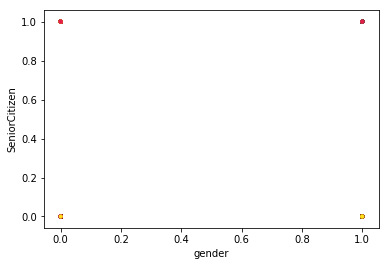

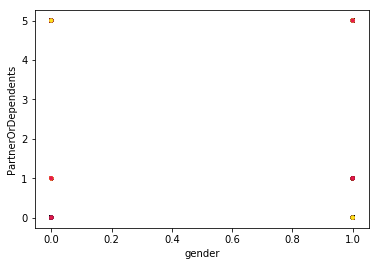

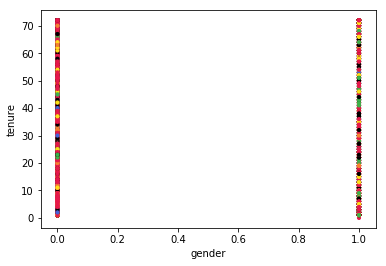

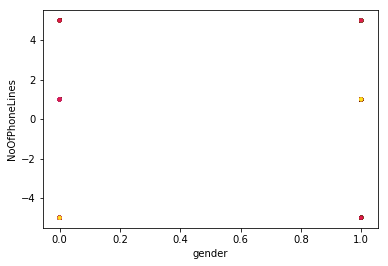

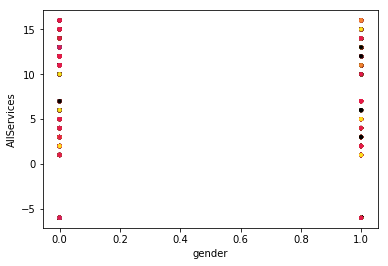

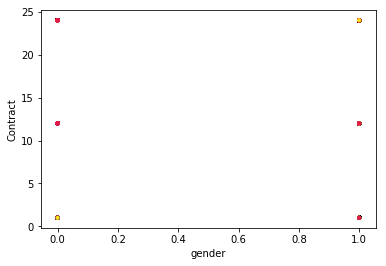

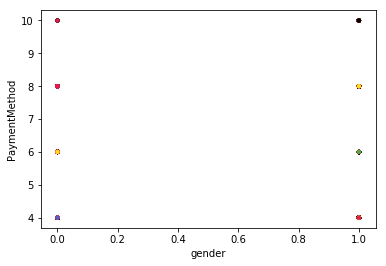

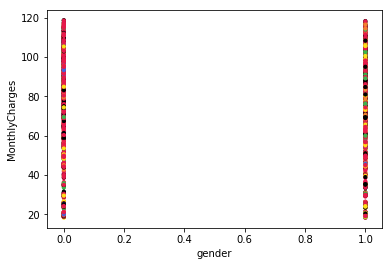

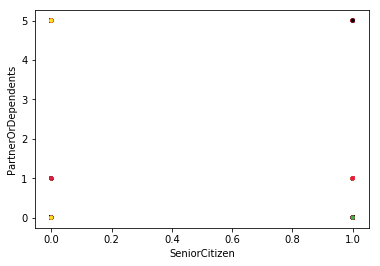

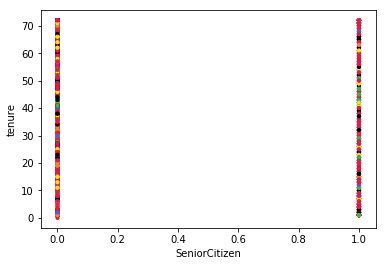

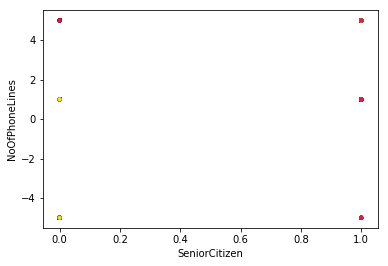

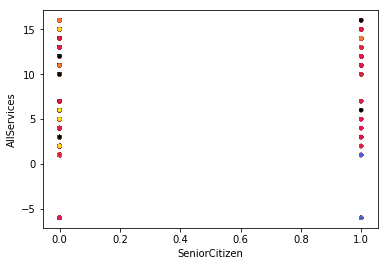

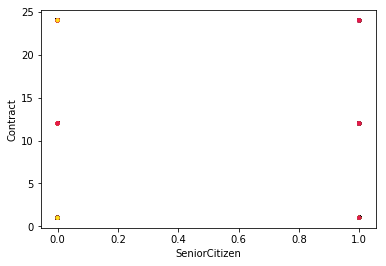

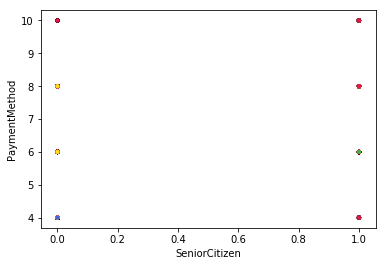

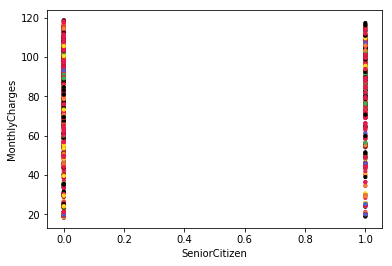

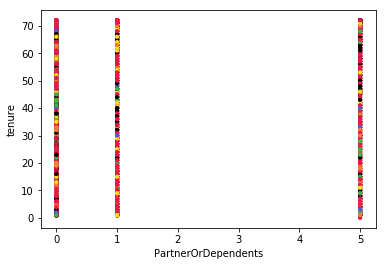

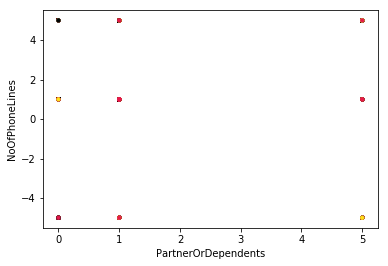

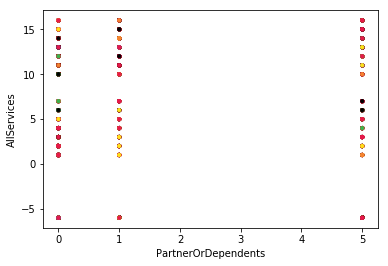

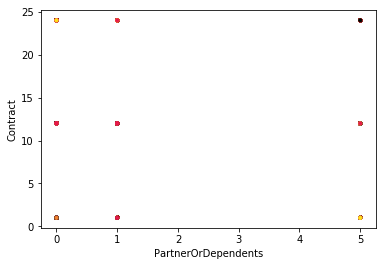

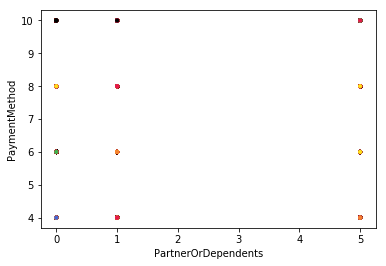

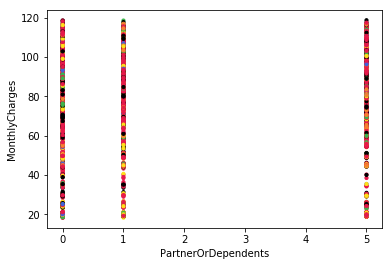

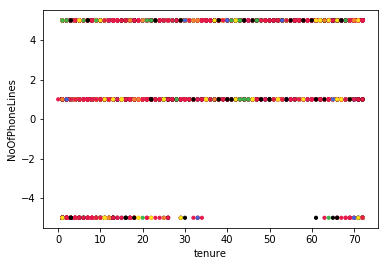

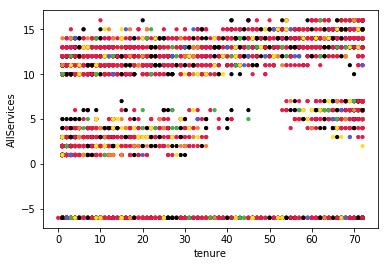

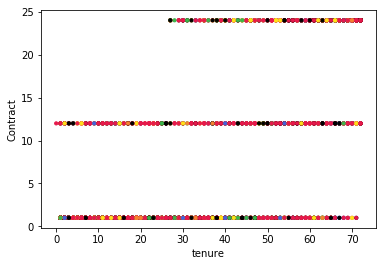

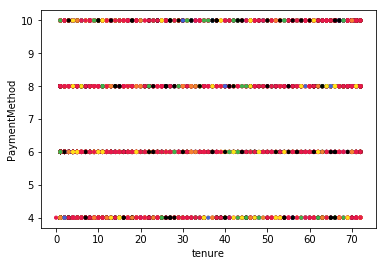

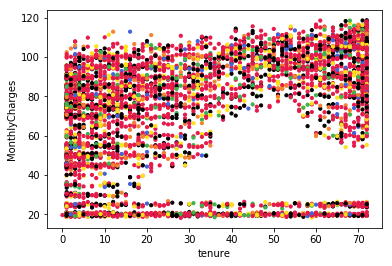

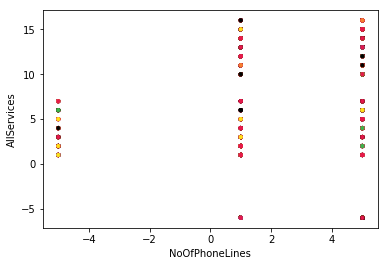

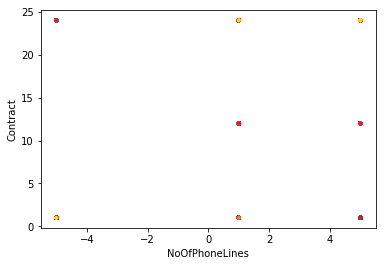

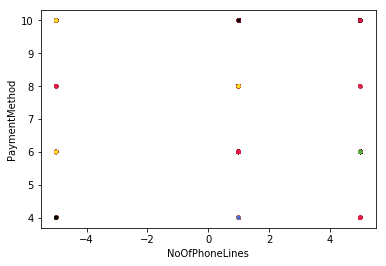

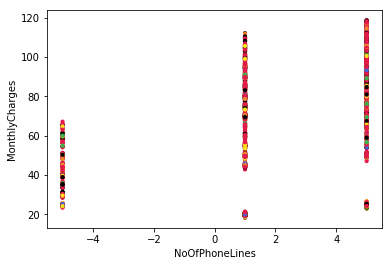

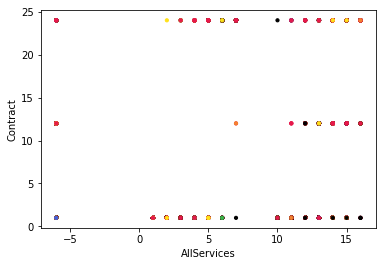

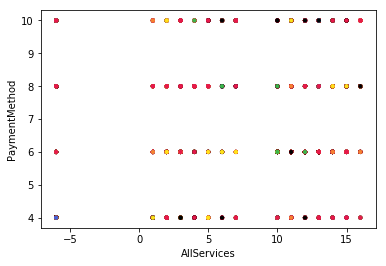

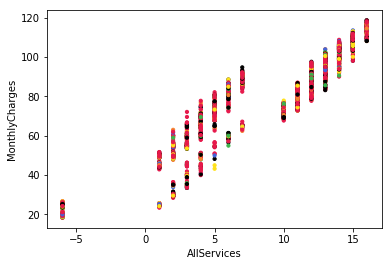

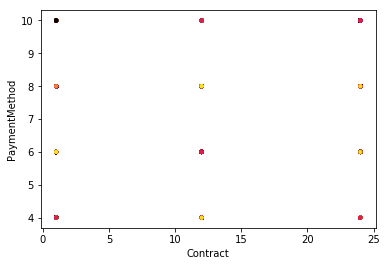

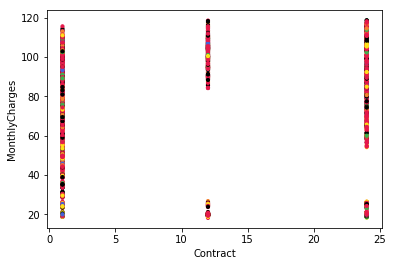

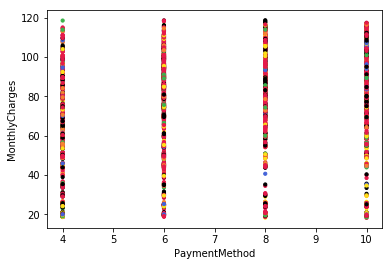

----------
----------


F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.


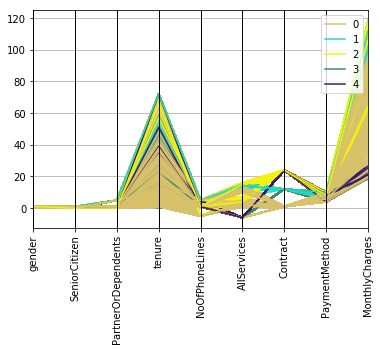

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.


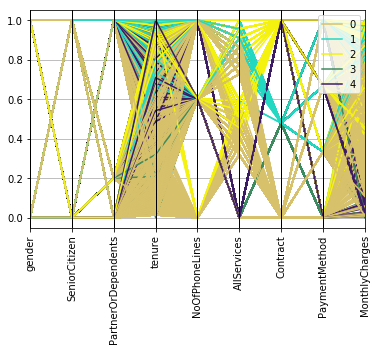

In [15]:
df2_red_clustered, df2_red_cluster_list = run_dbscan(df2_red, 'no', 10, 100)

In [5]:
import hdbscan

clust_count = np.linspace(1, 20, num=20, dtype='int')

clust_number = 2
plot_number = 1
plt.figure (figsize=(17,12))
while clust_number < 21:
    hdb = hdbscan.HDBSCAN(min_cluster_size=clust_number)
    hdb_pred = hdb.fit(unbal)
    plt.subplot(5, 4, plot_number, title = 'Min. Cluster Size = {}'.format(clust_number))
    plt.scatter(unbal[:,0], unbal[:,1], c=hdb_pred.labels_, cmap=cmap)
    plot_number += 1
    clust_number += 1

plt.tight_layout()

ModuleNotFoundError: No module named 'hdbscan'